In [1]:
import os
import imutils
import cv2
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow import keras
import gradio as gr
import numpy as np
import glob as gb
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
from pathlib import Path
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# Tensorflow version
print(tf.__version__)

2.12.0


In [3]:
devices_available = tf.test.gpu_device_name()
if len(devices_available) != 0:
    # Check available GPU devices.
    print("The following GPU devices are available: %s" % tf.test.gpu_device_name())
else:
    print("No GPU Available on this environment")

No GPU Available on this environment


In [4]:
# Data paths
DATASET_CSV_PATH = './input/dataset__labels.csv'
DATASET_DIR = './input'
ROOT_DIR = Path('./job')
#-------- directory to save logs and trained model----
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
DEFAULT_LOGS_DIR = 'logs' 

In [5]:
# load the csv file
raw_data = pd.read_csv(DATASET_CSV_PATH)
raw_data.head(12)


,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path
0,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2052.653343,695.836619,2210.117161,785.809054,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
1,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1110.682288,901.086237,1228.780152,982.623756,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
2,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1647.746382,912.332791,1791.150930,1002.305226,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
3,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2491.302550,1275.034169,2589.717436,1367.818243,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
4,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,3326.423156,1255.352699,3410.778773,1339.701857,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
5,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,877.298415,1511.211811,1017.891110,1592.749330,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
6,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,534.252240,799.867247,643.914542,903.897875,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
7,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1847.388008,1595.560969,1948.614748,1677.098488,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
8,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,3185.830462,1072.596191,3256.126809,1165.380264,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
9,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2170.751206,1204.743204,2288.849070,1303.150555,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...


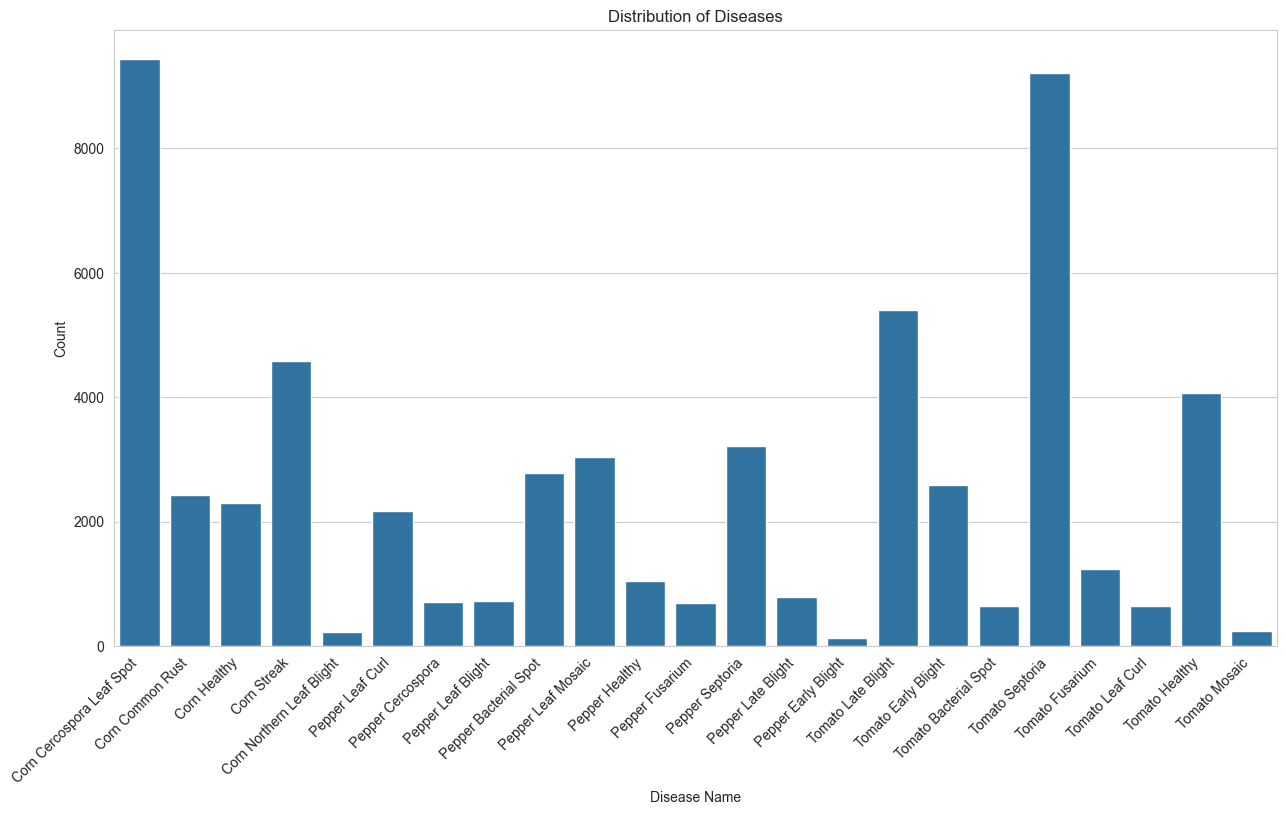

In [6]:
# Plot a bar chart using Seaborn
plt.figure(figsize=(15, 8))
sns.countplot(x='disease', data=raw_data)
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Diseases')
plt.xlabel('Disease Name')
plt.ylabel('Count')

# Show the plot
plt.show()


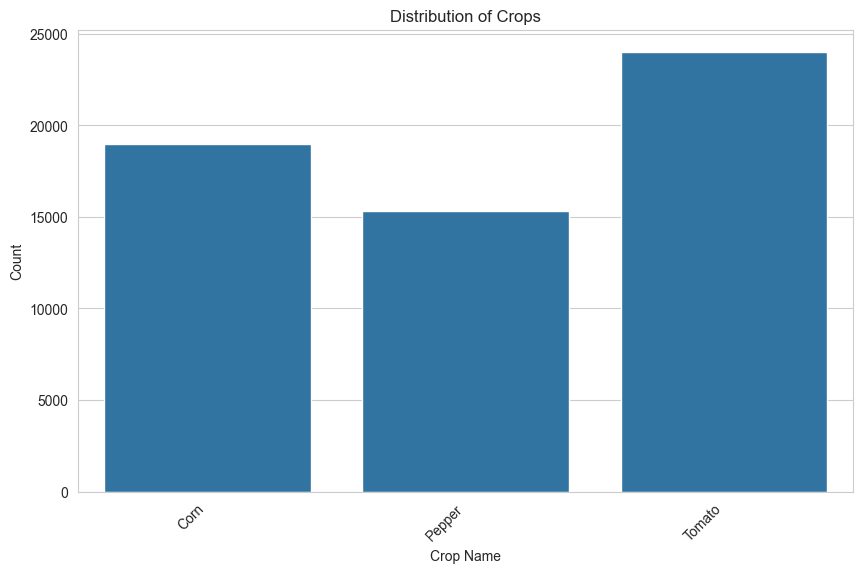

In [7]:
# Plot a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='crop', data=raw_data)
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Crops')
plt.xlabel('Crop Name')
plt.ylabel('Count')

# Show the plot
plt.show()


In [8]:
def replace_spaces(text):
    """
        Replaces all spaces in a string with a given character, except for the first space between the first two words.
    """
    words = text.split()
    new_word = words[0] + '__'
    for i in range(1, len(words)):
        new_word = new_word + words[i] + " "
    prep_word = new_word.lstrip().rstrip()
    return prep_word.replace(" ", "_")



In [9]:
def plot_image_with_bounding_boxes(
        image_file_name : str,
        font_size: int = 28, 
        thickness : int =4,
        margin: int = 5,
        fill : str ='black',
        outline : str ="red",
        display_strings: any = None,
        confidence_scores : any = None,
        boxes: any = [],
):
    _image = Image.open(image_file_name)
    # Set the font size
    font = ImageFont.truetype("arial.ttf", font_size)        
    _image_annotated = _image.copy()
    img_b_box = ImageDraw.Draw(_image_annotated)
    for index in range(len(boxes)):
        b_box = boxes[index]
        display_text = f"{display_strings[index]} {int(100 *  confidence_scores[index])}%"
        img_b_box.rectangle(b_box, outline=outline, width=thickness)
        img_b_box.text((b_box[0], b_box[1] - margin), display_text, fill=fill, font=font)
    return display_image(_image_annotated)

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def plot_image(file_path):
    _image = Image.open(file_path)
    return _image

def load_img(path):
  _img = tf.io.read_file(path)
  _img = tf.image.decode_jpeg(_img, channels=3)
  return _img

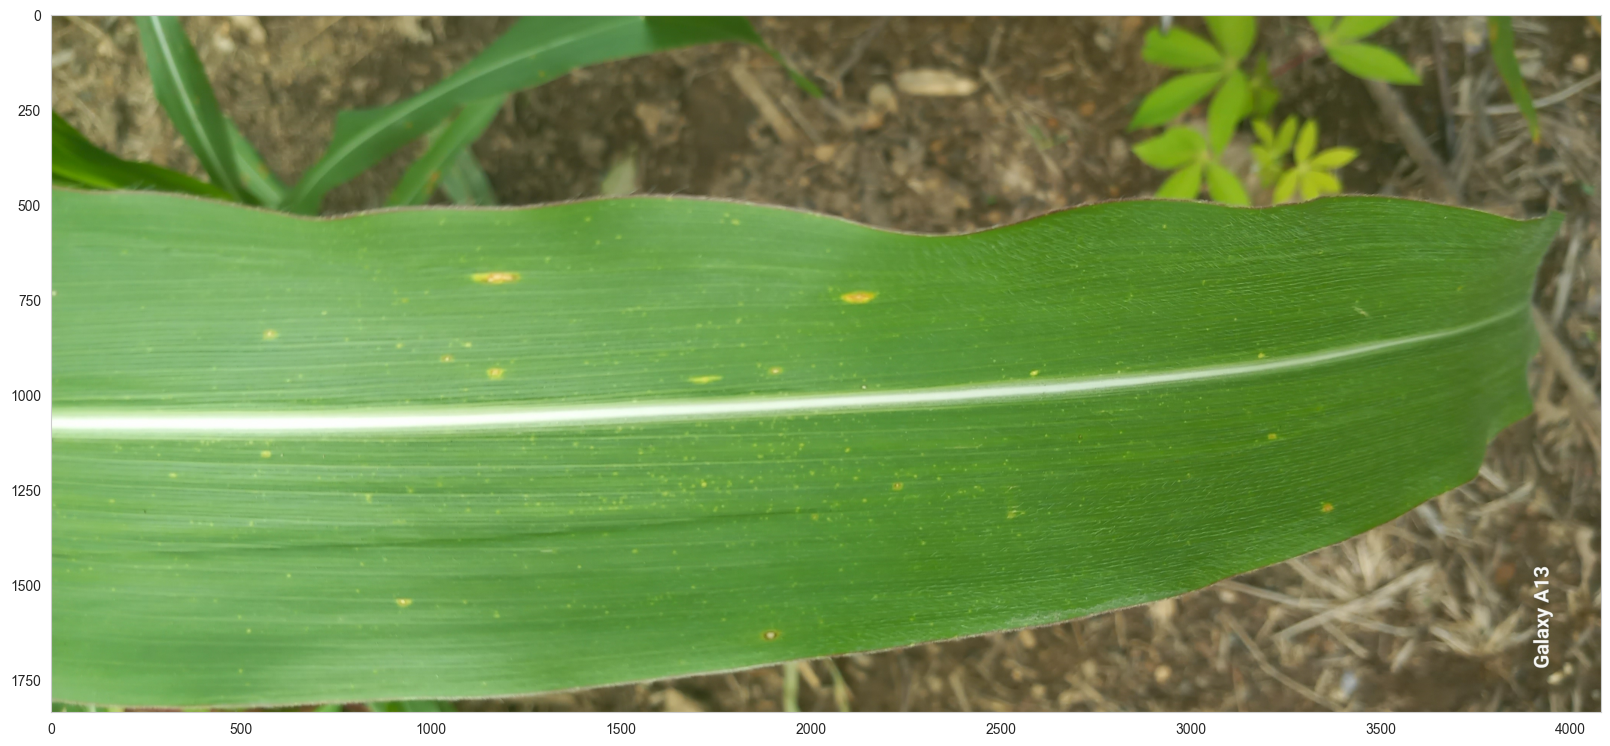

In [10]:
display_image(load_img(raw_data['img_path'].iloc[0]))

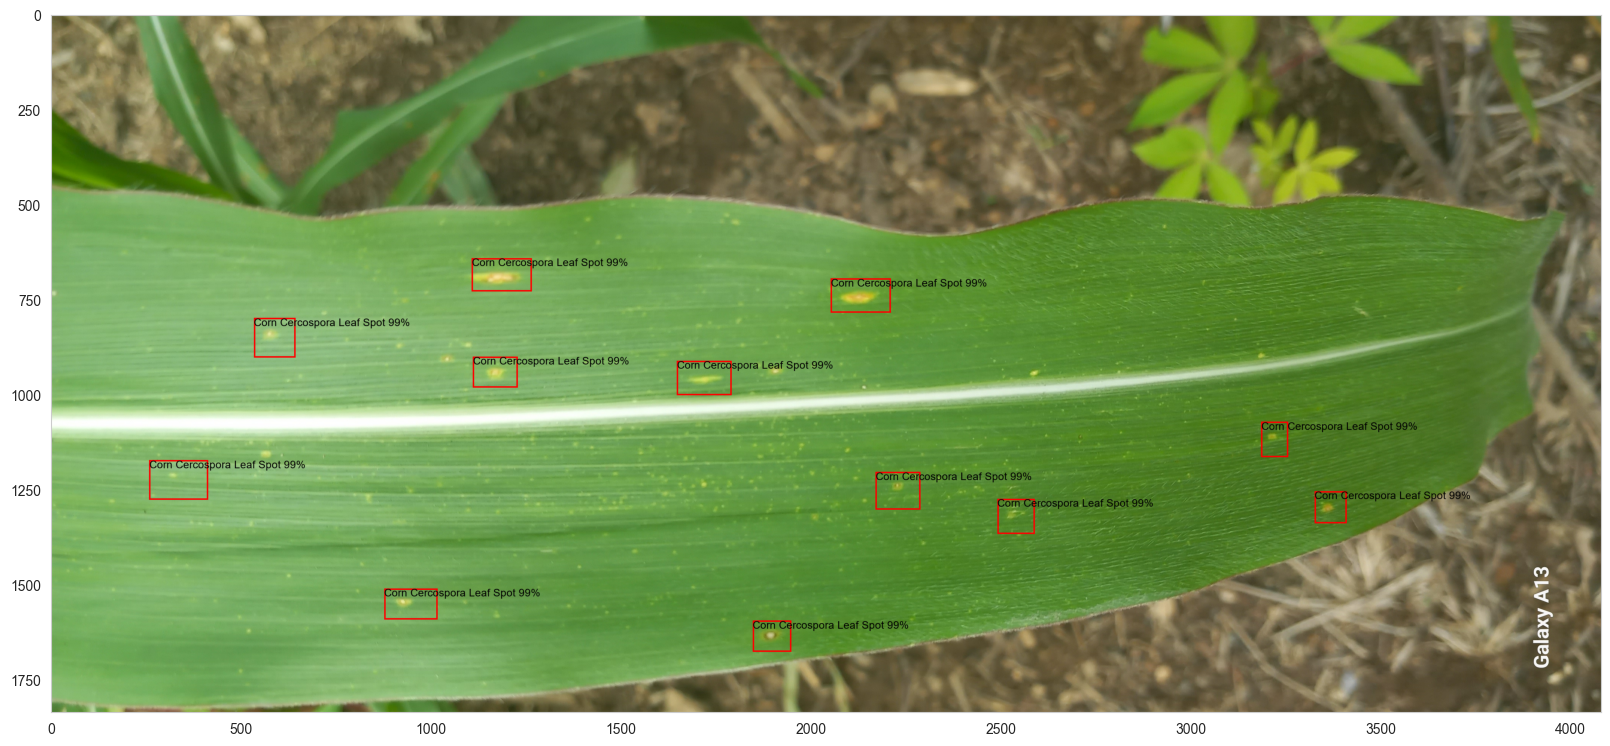

In [11]:
image_path = raw_data['img_path'].iloc[0]
boxes = []
classes = []
scores = []
for _index, _row in raw_data[raw_data['img_path'] == image_path].iterrows():
    # print(_row)
    xmin = float(_row['xmin'])
    ymin = float(_row['ymin'])
    xmax = float(_row['xmax'])
    ymax = float(_row['ymax'])
    boxes.append([xmin, ymin, xmax, ymax])
    classes.append(str(_row['disease']))
    scores.append(0.99)

plot_image_with_bounding_boxes(image_file_name=raw_data['img_path'].iloc[0], display_strings=classes, confidence_scores=scores, boxes=boxes)